<a href="https://colab.research.google.com/github/ashikha-03/State_Name_Classification_with_typos/blob/main/state_final_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from fuzzywuzzy import process, fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# GRU Model
class Seq2SeqWithGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, num_layers=2, dropout=0.3):
        super(Seq2SeqWithGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Encoder
        self.encoder = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

        # Decoder
        self.decoder = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_seq, target_seq=None, teacher_forcing_ratio=0.5):
        embedded = self.embedding(input_seq)

        # Encoder
        _, hidden = self.encoder(embedded)

        # Decoder
        batch_size, seq_len = input_seq.shape
        decoder_input = input_seq[:, 0].unsqueeze(1)
        outputs = torch.zeros(batch_size, seq_len, len(char2idx)).to(input_seq.device)

        for t in range(seq_len):
            decoder_input_emb = self.embedding(decoder_input)
            output, hidden = self.decoder(decoder_input_emb, hidden)
            output = self.fc(output.squeeze(1))
            outputs[:, t, :] = output

            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target_seq[:, t].unsqueeze(1)
            else:
                decoder_input = output.argmax(dim=1, keepdim=True)

        return outputs


In [ ]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(char2idx)
model = Seq2SeqWithGRU(vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0, reduction="none")
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training function
def train_model(model, train_loader, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct, total = 0, 0  # Track accuracy
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, targets)  # Enable teacher forcing

            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss = (loss * (targets.view(-1) != 0).float()).mean()  # Mask padding
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            correct += (outputs.argmax(dim=-1) == targets).sum().item()
            total += targets.numel()

        accuracy = correct / total
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")


In [ ]:
# Train the model
train_model(model, train_loader)

Epoch 1, Loss: 0.3535, Accuracy: 0.3372
Epoch 2, Loss: 0.0081, Accuracy: 0.4321
Epoch 3, Loss: 0.0041, Accuracy: 0.4326
Epoch 4, Loss: 0.0028, Accuracy: 0.4329
Epoch 5, Loss: 0.0014, Accuracy: 0.4331
Epoch 6, Loss: 0.0019, Accuracy: 0.4330
Epoch 7, Loss: 0.0019, Accuracy: 0.4330
Epoch 8, Loss: 0.0004, Accuracy: 0.4332
Epoch 9, Loss: 0.0007, Accuracy: 0.4332
Epoch 10, Loss: 0.0046, Accuracy: 0.4324
Epoch 11, Loss: 0.0019, Accuracy: 0.4330
Epoch 12, Loss: 0.0003, Accuracy: 0.4332
Epoch 13, Loss: 0.0003, Accuracy: 0.4332
Epoch 14, Loss: 0.0022, Accuracy: 0.4328
Epoch 15, Loss: 0.0026, Accuracy: 0.4328
Epoch 16, Loss: 0.0010, Accuracy: 0.4331
Epoch 17, Loss: 0.0020, Accuracy: 0.4329
Epoch 18, Loss: 0.0011, Accuracy: 0.4331
Epoch 19, Loss: 0.0002, Accuracy: 0.4332
Epoch 20, Loss: 0.0003, Accuracy: 0.4332
Epoch 21, Loss: 0.0012, Accuracy: 0.4330
Epoch 22, Loss: 0.0002, Accuracy: 0.4332
Epoch 23, Loss: 0.0006, Accuracy: 0.4331
Epoch 24, Loss: 0.0007, Accuracy: 0.4331
Epoch 25, Loss: 0.0045, A

In [ ]:
# Decode output sequence
def decode_sequence(seq):
    return "".join(idx2char[idx] for idx in seq if idx in idx2char and idx2char[idx] != "<PAD>")

In [ ]:
# Model prediction function
def predict_with_model(input_str):
    model.eval()
    input_tensor = torch.tensor([encode_sequence(input_str)], dtype=torch.long).to(device)
    with torch.no_grad():
        output_tensor = model(input_tensor)
        predicted_seq = torch.argmax(output_tensor, dim=-1).squeeze().tolist()
    return decode_sequence(predicted_seq)

In [ ]:
# Hybrid Correction Function
def correct_state_name(misspelled_name):
    if not isinstance(misspelled_name, str) or misspelled_name.strip() == "":
        return "UNKNOWN"

    misspelled_name = misspelled_name.lower().strip()

    #  Fuzzy Matching
    fuzzy_match, fuzzy_score = process.extractOne(misspelled_name, correct_states, scorer=fuzz.ratio)
    if fuzzy_score >= 80:
        return fuzzy_match  #  Return if match is confident

    # Use GRU model for low-confidence matches
    gru_pred = predict_with_model(misspelled_name)

    # Refine using fuzzywuzzy again after GRU model's prediction
    fuzzy_match_after_gru, fuzzy_score_after_gru = process.extractOne(gru_pred, correct_states, scorer=fuzz.ratio)
    return fuzzy_match_after_gru  # Return if the GRU output is a good match

In [ ]:
# Apply corrections
df["correctstatename_final"] = df["incorrectstatename"].apply(correct_state_name)

In [ ]:
# Classification Report
y_true = df["correctstatename"].tolist()
y_pred = df["correctstatename_final"].tolist()
report = classification_report(y_true, y_pred, zero_division=1)
print("Classification Report:\n", report)

Classification Report:
                       precision    recall  f1-score   support

             alabama       0.99      1.00      1.00       300
              alaska       0.99      0.52      0.68       300
             arizona       1.00      1.00      1.00       300
            arkansas       0.26      0.99      0.41       300
          california       1.00      1.00      1.00       300
            colorado       0.90      1.00      0.95       300
         connecticut       1.00      1.00      1.00       300
            delaware       1.00      0.79      0.88       300
district of columbia       1.00      1.00      1.00       300
             florida       1.00      0.98      0.99       300
             georgia       1.00      1.00      1.00       300
              hawaii       1.00      0.75      0.86       300
               idaho       1.00      0.70      0.82       300
            illinois       1.00      1.00      1.00       300
             indiana       0.93      1.00    

In [ ]:
# Save output
df.to_csv("corrected_states_final.csv", index=False)
print("Correction completed! Results saved in corrected_states_final.csv")


Correction completed! Results saved in corrected_states_final.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

In [ ]:
# Load corrected data
df = pd.read_csv("corrected_states_final.csv")

<ipython-input-19-84740e6f8ffe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")


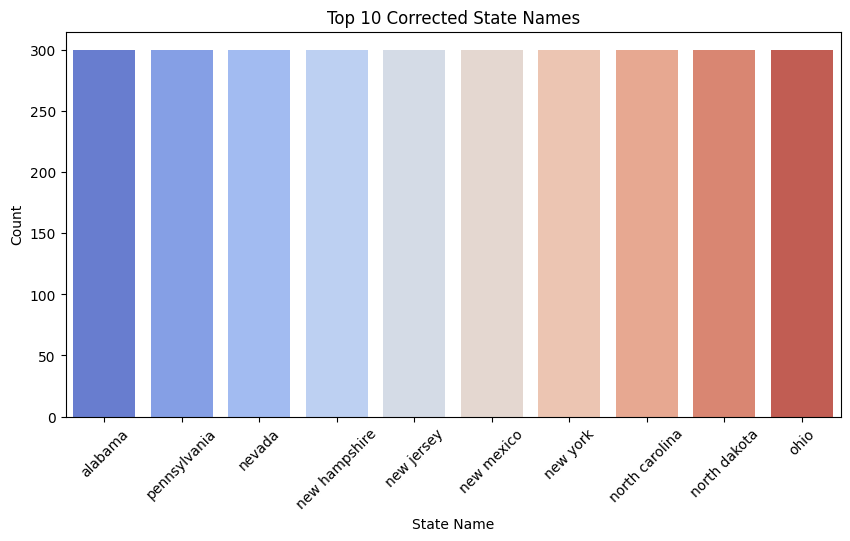

In [ ]:
# Plot 1: Accuracy per State (Top 10)
state_counts = df["correctstatename"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")
plt.title("Top 10 Corrected State Names")
plt.xlabel("State Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Plot 2: Fuzzy Matching vs. Model Correction Comparison
df["match_type"] = df.apply(lambda row: "Fuzzy Match" if row["correctstatename"] == row["correctstatename_final"] else "Model Corrected", axis=1)
match_counts = df["match_type"].value_counts()


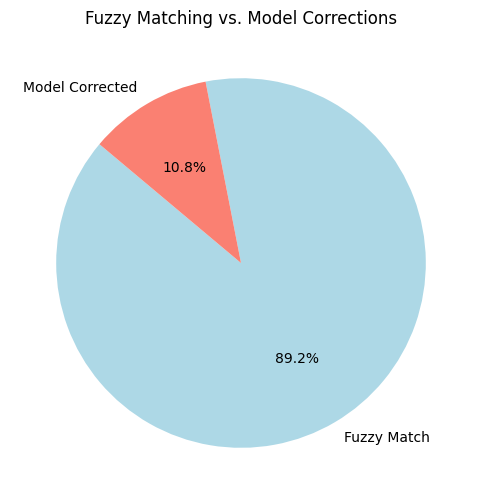

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(match_counts, labels=match_counts.index, autopct="%1.1f%%", colors=["lightblue", "salmon"], startangle=140)
plt.title("Fuzzy Matching vs. Model Corrections")
plt.show()


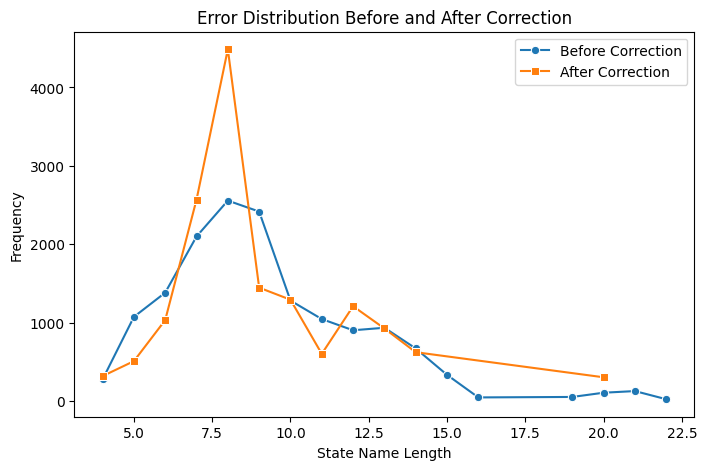

In [ ]:
# Plot 3: Error Distribution Before and After Correction
incorrect_counts = Counter(df["incorrectstatename"].str.len())
corrected_counts = Counter(df["correctstatename_final"].str.len())

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(incorrect_counts.keys()), y=list(incorrect_counts.values()), marker="o", label="Before Correction")
sns.lineplot(x=list(corrected_counts.keys()), y=list(corrected_counts.values()), marker="s", label="After Correction")
plt.title("Error Distribution Before and After Correction")
plt.xlabel("State Name Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()
